### Imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

### Helper Functions

In [2]:
def reverseChannels(img):
    """
    Reverses the colour channels of an image
    for better visualization using matplotlib.

    Parameters:
        img: NumPy array. Input image
    
    Returns:
        NumPy array. Image with reversed colour channels
    """
    return img[:,:,::-1]

### Energy Function

$$e_1\textbf{I}=|\frac{\partial}{\partial x}\textbf{I}|+|\frac{\partial}{\partial y}\textbf{I}|$$

In [3]:
# energy function

def energyFunction(img, k):
    """
    Calculates and returns the energy function
    of an image by using magnitude of the first
    derivative.
    
    Parameters:
        img: NumPy array.
        k: int. Kernel size for the Sobel operator.
    Returns:
        NumPy array. Energy function of the image
    """

    # pad the image
    img = np.pad(img, ((k//2, k//2), (k//2, k//2), (0, 0)), constant_values=0)

    # define Sobel filters
    sobelX = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=k)
    sobelY = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=k)

    # return np.sqrt(sobelX**2 + sobelY**2)
    return (np.abs(sobelX) + np.abs(sobelY)).astype(np.uint8)[k//2:-k//2 + 1, k//2:-k//2 + 1], (np.abs(sobelX) + np.abs(sobelY))[k//2:-k//2 + 1, k//2:-k//2 + 1]

### Energy Map

In [4]:
def energyMap(eF):
    """
    Calculates the energy map by using the
    seam carving algorithm and returns the
    final energy map.

    Parameters:
        eF: NumPy array. Energy function of
            the image. From energyFunction().
    Returns:
        NumPy array. Energy map of the image.
    """

    # initialize energy maps in x and y directions
    eMapX = np.zeros(eF.shape, dtype=np.int32)
    eMapY = np.zeros(eF.shape, dtype=np.int32)

    # copy the last row of the energy function
    eMapX[-1] = eF[-1]

    # copy the last column of the energy function
    eMapY[:,-1] = eF[:,-1]

    # calculate the energy map in x direction
    for i in range(eF.shape[0] - 2, -1, -1):
        for j in range(eF.shape[1]):
            if j == 0:
                eMapX[i,j][0] = eF[i,j][0] + min(eMapX[i+1,j][0], eMapX[i+1,j+1][0])
                eMapX[i,j][1] = eF[i,j][1] + min(eMapX[i+1,j][1], eMapX[i+1,j+1][1])
                eMapX[i,j][2] = eF[i,j][2] + min(eMapX[i+1,j][2], eMapX[i+1,j+1][2])
            elif j == eF.shape[1] - 1:
                eMapX[i,j][0] = eF[i,j][0] + min(eMapX[i+1,j-1][0], eMapX[i+1,j][0])
                eMapX[i,j][1] = eF[i,j][1] + min(eMapX[i+1,j-1][1], eMapX[i+1,j][1])
                eMapX[i,j][2] = eF[i,j][2] + min(eMapX[i+1,j-1][2], eMapX[i+1,j][2])
            else:
                eMapX[i,j][0] = eF[i,j][0] + min(eMapX[i+1,j-1][0], eMapX[i+1,j][0], eMapX[i+1,j+1][0])
                eMapX[i,j][1] = eF[i,j][1] + min(eMapX[i+1,j-1][1], eMapX[i+1,j][1], eMapX[i+1,j+1][1])
                eMapX[i,j][2] = eF[i,j][2] + min(eMapX[i+1,j-1][2], eMapX[i+1,j][2], eMapX[i+1,j+1][2])
    
    # calculate the energy map in y direction
    for i in range(eF.shape[1] - 2, -1, -1):
        for j in range(eF.shape[0]):
            if j == 0:
                eMapY[j,i][0] = eF[j,i][0] + min(eMapY[j,i+1][0], eMapY[j+1,i+1][0])
                eMapY[j,i][1] = eF[j,i][1] + min(eMapY[j,i+1][1], eMapY[j+1,i+1][1])
                eMapY[j,i][2] = eF[j,i][2] + min(eMapY[j,i+1][2], eMapY[j+1,i+1][2])
            elif j == eF.shape[0] - 1:
                eMapY[j,i][0] = eF[j,i][0] + min(eMapY[j-1,i+1][0], eMapY[j,i+1][0])
                eMapY[j,i][1] = eF[j,i][1] + min(eMapY[j-1,i+1][1], eMapY[j,i+1][1])
                eMapY[j,i][2] = eF[j,i][2] + min(eMapY[j-1,i+1][2], eMapY[j,i+1][2])
            else:
                eMapY[j,i][0] = eF[j,i][0] + min(eMapY[j-1,i+1][0], eMapY[j,i+1][0], eMapY[j+1,i+1][0])
                eMapY[j,i][1] = eF[j,i][1] + min(eMapY[j-1,i+1][1], eMapY[j,i+1][1], eMapY[j+1,i+1][1])
                eMapY[j,i][2] = eF[j,i][2] + min(eMapY[j-1,i+1][2], eMapY[j,i+1][2], eMapY[j+1,i+1][2])

    return eMapX, eMapY

In [5]:
def plotMaps(path, k):
    """
    Plots the energy maps of the image.

    Parameters:
        path: String. Path to the image.
        k: int. Kernel size for the Sobel operator.
    Returns:
        None.
    """

    # read the image
    img = reverseChannels(cv2.imread(path))

    # calculate the energy function
    eF = energyFunction(img, k)

    # calculate the energy maps
    eMapX, eMapY = energyMap(eF[1])

    # scale the energy maps to 0-255
    eMapXscaled = cv2.normalize(
        eMapX, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    eMapYscaled = cv2.normalize(
        eMapY, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    # plot the energy maps
    fig, ax = plt.subplots(2, 2, figsize=(30, 20))
    ax[0, 0].imshow(img)
    ax[0, 0].set_title('Original Image')
    ax[0, 1].imshow(255 - eF[0])
    ax[0, 1].set_title('Energy Function')
    ax[1, 0].imshow(255 - eMapXscaled)
    ax[1, 0].set_title('Energy Map in X Direction')
    ax[1, 1].imshow(255 - eMapYscaled)
    ax[1, 1].set_title('Energy Map in Y Direction')
    plt.show()

    return None

### Seam Finding

In [6]:
def verticalSeam(eMapX, starts, opt):
    """
    Function that finds the optimal seam
    by backtracking the energy map.

    Parameters:
        eMapX: NumPy array. The energy map
            in the x-direction computed
            by the energyMap function.
        starts: NumPy array. Starting points
            to backtrack from
        opt: Boolean. Checks whether we're
            marking the optimal seam.
    Returns:
        seam: NumPy array. The optimal
              seam marked in red.
    """

    # initialize the seam
    seam = np.zeros(eMapX.shape, dtype=np.uint8)

    if opt == True:
        # find the starting point
        start0 = np.argmin(eMapX[0, :, 0])
        start1 = np.argmin(eMapX[0, :, 1])
        start2 = np.argmin(eMapX[0, :, 2])

        # backtrack the energy map from the starting point
        # and mark the seam in red for each channel
        seam[0, start0, 0] = 255
        seam[0, start1, 1] = 255
        seam[0, start2, 2] = 255

        for i in range(1, eMapX.shape[0]):
            if start0 == 0:
                start0 = np.argmin(eMapX[i, start0:start0+2, 0]) + start0
            elif start0 == eMapX.shape[1] - 1:
                start0 = np.argmin(eMapX[i, start0-1:start0+1, 0]) + start0 - 1
            else:
                start0 = np.argmin(eMapX[i, start0-1:start0+2, 0]) + start0 - 1

            if start1 == 0:
                start1 = np.argmin(eMapX[i, start1:start1+2, 1]) + start1
            elif start1 == eMapX.shape[1] - 1:
                start1 = np.argmin(eMapX[i, start1-1:start1+1, 1]) + start1 - 1
            else:
                start1 = np.argmin(eMapX[i, start1-1:start1+2, 1]) + start1 - 1

            if start2 == 0:
                start2 = np.argmin(eMapX[i, start2:start2+2, 2]) + start2
            elif start2 == eMapX.shape[1] - 1:
                start2 = np.argmin(eMapX[i, start2-1:start2+1, 2]) + start2 - 1
            else:
                start2 = np.argmin(eMapX[i, start2-1:start2+2, 2]) + start2 - 1

            seam[i, (start0 + start1 + start2) // 3, :] = 255
    else:
        # get starting point from starts
        start0 = starts[0]
        start1 = starts[1]
        start2 = starts[2]

        # backtrack the energy map from the starting point
        # and mark the seam in red for each channel
        seam[0, start0, 0] = 255
        seam[0, start1, 1] = 255
        seam[0, start2, 2] = 255

        for i in range(1, eMapX.shape[0]):
            if start0 == 0:
                start0 = np.argmin(eMapX[i, start0:start0+2, 0]) + start0
            elif start0 == eMapX.shape[1] - 1:
                start0 = np.argmin(eMapX[i, start0-1:start0+1, 0]) + start0 - 1
            else:
                start0 = np.argmin(eMapX[i, start0-1:start0+2, 0]) + start0 - 1

            if start1 == 0:
                start1 = np.argmin(eMapX[i, start1:start1+2, 1]) + start1
            elif start1 == eMapX.shape[1] - 1:
                start1 = np.argmin(eMapX[i, start1-1:start1+1, 1]) + start1 - 1
            else:
                start1 = np.argmin(eMapX[i, start1-1:start1+2, 1]) + start1 - 1

            if start2 == 0:
                start2 = np.argmin(eMapX[i, start2:start2+2, 2]) + start2
            elif start2 == eMapX.shape[1] - 1:
                start2 = np.argmin(eMapX[i, start2-1:start2+1, 2]) + start2 - 1
            else:
                start2 = np.argmin(eMapX[i, start2-1:start2+2, 2]) + start2 - 1

            seam[i, (start0 + start1 + start2) // 3, :] = 255

    return seam


def horizontalSeam(eMapY, starts, opt):
    """
    Function that finds the optimal seam
    by backtracking the energy map.

    Parameters:
        eMapY: NumPy array. The energy map
            in the y-direction computed
            by the energyMap function.
        starts: NumPy array. Starting points
            to backtrack from
        opt: Boolean. Checks whether we're
            marking the optimal seam.
    Returns:
        seam: NumPy array. The optimal
                seam marked in red.
    """

    # initialize the seam
    seam = np.zeros(eMapY.shape, dtype=np.uint8)

    if opt == True:
        # find the starting point
        start0 = np.argmin(eMapY[:, 0, 0])
        start1 = np.argmin(eMapY[:, 0, 1])
        start2 = np.argmin(eMapY[:, 0, 2])

        # backtrack the energy map from the starting point
        # and mark the seam in red for each channel
        seam[start0, 0, 0] = 255
        seam[start1, 0, 1] = 255
        seam[start2, 0, 2] = 255

        for i in range(1, eMapY.shape[1]):
            if start0 == 0:
                start0 = np.argmin(eMapY[start0:start0+2, i, 0]) + start0
            elif start0 == eMapY.shape[0] - 1:
                start0 = np.argmin(eMapY[start0-1:start0+1, i, 0]) + start0 - 1
            else:
                start0 = np.argmin(eMapY[start0-1:start0+2, i, 0]) + start0 - 1

            if start1 == 0:
                start1 = np.argmin(eMapY[start1:start1+2, i, 1]) + start1
            elif start1 == eMapY.shape[0] - 1:
                start1 = np.argmin(eMapY[start1-1:start1+1, i, 1]) + start1 - 1
            else:
                start1 = np.argmin(eMapY[start1-1:start1+2, i, 1]) + start1 - 1

            if start2 == 0:
                start2 = np.argmin(eMapY[start2:start2+2, i, 1]) + start2
            elif start2 == eMapY.shape[0] - 1:
                start2 = np.argmin(eMapY[start2-1:start2+1, i, 1]) + start2 - 1
            else:
                start2 = np.argmin(eMapY[start2-1:start2+2, i, 1]) + start2 - 1

            seam[(start0 + start1 + start2) // 3, i, :] = 255
    else:
        # get starting point from starts
        start0 = starts[0]
        start1 = starts[1]
        start2 = starts[2]

        # backtrack the energy map from the starting point
        # and mark the seam in red for each channel
        seam[start0, 0, 0] = 255
        seam[start1, 0, 1] = 255
        seam[start2, 0, 2] = 255

        for i in range(1, eMapY.shape[1]):
            if start0 == 0:
                start0 = np.argmin(eMapY[start0:start0+2, i, 0]) + start0
            elif start0 == eMapY.shape[0] - 1:
                start0 = np.argmin(eMapY[start0-1:start0+1, i, 0]) + start0 - 1
            else:
                start0 = np.argmin(eMapY[start0-1:start0+2, i, 0]) + start0 - 1

            if start1 == 0:
                start1 = np.argmin(eMapY[start1:start1+2, i, 1]) + start1
            elif start1 == eMapY.shape[0] - 1:
                start1 = np.argmin(eMapY[start1-1:start1+1, i, 1]) + start1 - 1
            else:
                start1 = np.argmin(eMapY[start1-1:start1+2, i, 1]) + start1 - 1

            if start2 == 0:
                start2 = np.argmin(eMapY[start2:start2+2, i, 1]) + start2
            elif start2 == eMapY.shape[0] - 1:
                start2 = np.argmin(eMapY[start2-1:start2+1, i, 1]) + start2 - 1
            else:
                start2 = np.argmin(eMapY[start2-1:start2+2, i, 1]) + start2 - 1

            seam[(start0 + start1 + start2) // 3, i, :] = 255

    return seam


In [7]:
def plotSeamOpt(path, k):
    """
    Plots the optimal seam in the vertical and
    horizontal direction for the input image.

    Parameters:
        path: String. Path to the image.
        k: int. Kernel size for the Sobel operator.
    Returns:
        None.
    """
    
    img = reverseChannels(cv2.imread(path))

    eF = energyFunction(img, k)
    eMapX, eMapY = energyMap(eF[1])

    # scale everything to 0-255 (just for plotting)
    eMapXscaled = cv2.normalize(eMapX, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    eMapYscaled = cv2.normalize(eMapY, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    vSeam = verticalSeam(eMapXscaled)
    hSeam = horizontalSeam(eMapYscaled)
    
    fig, ax = plt.subplots(2, 2, figsize=(30, 20))
    ax[0, 0].imshow(255 - eMapXscaled)
    ax[0, 0].set_title('Energy Map in X Direction')
    ax[0, 1].imshow(255 - vSeam)
    ax[0, 1].set_title('Vertical Seam')
    ax[1, 0].imshow(255 - eMapYscaled)
    ax[1, 0].set_title('Energy Map in Y Direction')
    ax[1, 1].imshow(255 - hSeam)
    ax[1, 1].set_title('Horizontal Seam')
    plt.show()

### Multiple Seams

In [ ]:
def markSeams(path, k, nx, ny):
    """
    Function that marks the optimal n seams
    in the vertical direction.

    Parameters:
        img: NumPy array. The original image.
        k: int. Kernel size for the Sobel operator.
        n: int. Number of seams to mark.
    """

    img = reverseChannels(cv2.imread(path))
    imgcpy1 = img.copy()
    imgcpy2 = img.copy()

    # compute the energy map
    eF = energyFunction(img, k)
    eMapX, eMapY = energyMap(eF[1])

    # scale everything to 0-255
    eMapXscaled = cv2.normalize(
        eMapX, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    eMapYscaled = cv2.normalize(
        eMapY, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    # find n least starting points for each channel
    start = np.zeros((nx, 3), dtype=np.int32)
    for i in range(3):
        start[:, i] = np.argsort(eMapXscaled[:, :, i][0, :].flatten())[:nx]

    # mark the seams starting at the n least starting points
    for i in range(nx):
        vSeam = verticalSeam(eMapXscaled, start[i], False)
        imgcpy1[vSeam[:, :, 0] == 255, 0] = 255

    # find n least starting points for each channel
    start = np.zeros((ny, 3), dtype=np.int32)
    for i in range(3):
        start[:, i] = np.argsort(eMapYscaled[:, :, i][:, 0].flatten())[:ny]
    
    # mark the seams starting at the n least starting points
    for i in range(ny):
        hSeam = horizontalSeam(eMapYscaled, start[i], False)
        imgcpy2[hSeam[:, :, 0] == 255, 0] = 255

    fig, ax = plt.subplots(1, 1, figsize=(30, 20))
    ax.imshow(imgcpy1)
    ax.set_title('Vertical Seam Marking')
    fig, ax = plt.subplots(1, 1, figsize=(30, 20))
    ax.imshow(imgcpy2)
    ax.set_title('Horizontal Seam Marking')
    return None

### Seam Removal

In [114]:
def seamRemovalX(img, k):
    """
    Function that removes the optimal seam
    in the vertical direction.

    Parameters:
        img: NumPy array. The original image.
        k: int. Kernel size for the Sobel operator.
    Returns:
        out: NumPy array. The image with the
             optimal seam removed.
    """

    # compute the energy map
    eF = energyFunction(img, k)
    eMapX, eMapY = energyMap(eF[1])

    # scale everything to 0-255
    eMapXscaled = cv2.normalize(eMapX, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    # find the optimal seam
    vSeam = verticalSeam(eMapXscaled)

    # remove the seam
    out = np.zeros((img.shape[0], img.shape[1] - 1,
                   img.shape[2]), dtype=np.uint8)


    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if vSeam[i, j, 0] == 255:
                # keep the pixels to the left of the seam
                out[i, :j, :] = img[i, :j, :]
                # keep the pixels to the right of the seam
                out[i, j:, :] = img[i, j+1:, :]
                break

    return out

def seamRemovalY(img, k):
    """
    Function that removes the optimal seam
    in the horizontal direction.

    Parameters:
        img: NumPy array. The original image.
        k: int. Kernel size for the Sobel operator.
    Returns:
        out: NumPy array. The image with the
             optimal seam removed.
    """

    # compute the energy map
    eF = energyFunction(img, k)
    eMapX, eMapY = energyMap(eF[1])

    # scale everything to 0-255
    eMapYscaled = cv2.normalize(eMapY, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    # find the optimal seam
    hSeam = horizontalSeam(eMapYscaled)

    # remove the seam
    out = np.zeros((img.shape[0] - 1, img.shape[1],
                   img.shape[2]), dtype=np.uint8)

    for i in range(img.shape[1]):
        for j in range(img.shape[0]):
            if hSeam[j, i, 0] == 255:
                # keep the pixels above the seam
                out[:j, i, :] = img[:j, i, :]
                # keep the pixels below the seam
                out[j:, i, :] = img[j+1:, i, :]
                break

    return out


In [ ]:
def removeNseamsX(img, k, n):
    """
    Function that removes the optimal n seams
    in the vertical direction.

    Parameters:
        img: NumPy array. The original image.
        k: int. Kernel size for the Sobel operator.
        n: int. Number of seams to remove.
    Returns:
        out: NumPy array. The image with the
             optimal n seams removed.
    """

    for i in range(n):
        img = seamRemovalX(img, k)

    return img

def removeNseamsY(img, k, n):
    """
    Function that removes the optimal n seams
    in the horizontal direction.

    Parameters:
        img: NumPy array. The original image.
        k: int. Kernel size for the Sobel operator.
        n: int. Number of seams to remove.
    Returns:
        out: NumPy array. The image with the
             optimal n seams removed.
    """

    for i in range(n):
        img = seamRemovalY(img, k)

    return img

### Average Energy Plots

Finding how the average energy of the image changes on multiple resizing strategies.
1. Cropping
2. Seam Carving
3. Column Removal
4. Pixel Removal
5. Optimal Removal

In [ ]:
def avgEnergyPlots(path, k):
    """
    Function that plots the average energy as the
    number of seams removed increases for various
    strategies of seam removal.

    Parameters:
        path: string. Path to the image.
        k: int. Kernel size for the Sobel operator.
    Returns:
        None.
    """

    img = reverseChannels(cv2.imread(path))
    eF = energyFunction(img, k)

    widths = np.arange(0, 200, 20)
    crop = []
    column = []
    pixel = []
    optimal = []

    # for no removal append average energy
    crop.append(np.mean(eF[0]))
    column.append(np.mean(eF[0]))
    pixel.append(np.mean(eF[0]))
    optimal.append(np.mean(eF[0]))

    for i in range(len(widths)):

        # crop left most columns and average remaining energy
        crop.append(np.mean(eF[0][:, widths[i]:, :]))

        # find sums along columns
        columnsums = np.sum(eF[0], axis=0)
        # find the n least sums
        columnleast = np.argsort(columnsums[:, 0].flatten())[:widths[i]]
        # remove the least sum columns
        withoutcolumn = np.delete(eF[0], columnleast, axis=1)
        # average remaining energy
        column.append(np.mean(withoutcolumn))

        # find widths[i] min energy pixels in each row and make them 0
        withoutpixels = np.copy(eF[0])
        for j in range(eF[0].shape[0]):
            # find the n least sums
            pixelleast = np.argsort(eF[0][j, :, 0].flatten())[:widths[i]]
            # remove the least sum pixels
            withoutpixels[j, pixelleast, :] = 0
        # average remaining energy
        pixel.append(np.mean(withoutpixels))

        # find minimum value in energy map
        for j in range(widths[i]):
            for k in range(eF[0].shape[0]):
                # find the minimum value in energy map
                minval = np.min(eF[0])
                # find the indices of the minimum value
                minindices = np.argwhere(eF[0] == minval)
                # remove the minimum value
                eF[0][minindices[0][0], minindices[0][1], :] = 0
        # average remaining energy
        optimal.append(np.mean(eF[0]))



    
    # plot the average energy as the number of seams removed increases
    plt.plot(widths, crop, label='crop')
    plt.plot(widths, column, label='column')
    plt.plot(widths, pixel, label='pixel')
    plt.plot(widths, optimal, label='optimal')
    plt.xlabel('Number of seams removed')
    plt.ylabel('Average energy')
    plt.legend()
    plt.show()


In [2]:
def cropAE(eF):
    """
    Function that crops the left most columns
    and returns the average energy for different
    numbers of columns removed.

    Parameters:
        eF: NumPy array. The energy function.
    Returns:
        crop: NumPy array. The average energy
              for different numbers of columns
              removed.
    """

    eFcrop = np.copy(eF)
    widths = np.arange(0, 200, 20)
    crop = []

    for i in range(len(widths)):
        # crop left most columns
        eFcrop = eFcrop[:, widths[i]:, :]
        # average remaining energy
        crop.append(np.mean(eFcrop))
    
    return crop

def columnAE(eF):
    """
    Function that removes the least sum columns
    and returns the average energy for different
    numbers of columns removed.

    Parameters:
        eF: NumPy array. The energy function.
    Returns:
        column: NumPy array. The average energy
                for different numbers of columns
                removed.
    """

    eFcolumn = np.copy(eF)
    widths = np.arange(0, 200, 20)
    column = []

    for i in range(len(widths)):
        # find sums along columns
        columnsums = np.sum(eFcolumn, axis=0)
        # find the n least sums
        columnleast = np.argsort(columnsums[:, 0].flatten())[:widths[i]]
        # set all pixels in the least sum columns to 0
        eFcolumn[:, columnleast, :] = 0
        # sum remaining energy
        sum = np.sum(eFcolumn)
        # average remaining energy
        column.append(sum / (eFcolumn.shape[0] * eFcolumn.shape[1] - widths[i]))
        # set all pixels in the least sum columns to 255
        eFcolumn[:, columnleast, :] = 255
    
    return column

def pixelAE(eF):
    """
    Function that removes the least energy pixel
    in each row and returns the average energy
    for different numbers of pixels removed.

    Parameters:
        eF: NumPy array. The energy function.
    Returns:
        pixel: NumPy array. The average energy
               for different numbers of pixels
               removed.
    """

    eFpixel = np.copy(eF)
    widths = np.arange(0, 200, 20)
    pixel = []
    totalsum = np.sum(eFpixel)

    for i in range(len(widths)):
        sum = 0
        # find widths[i] min energy pixels in each row and make them 0
        for j in range(eFpixel.shape[0]):
            # find the n least sums
            pixelleast = np.argsort(eFpixel[j, :, 0].flatten())[:widths[i]]
            # remove the least sum pixels
            eFpixel[j, pixelleast, :] = 0
            # sum remaining energy in the row
            sum += np.sum(eFpixel[j, :, :])
            # set the least sum pixels to 255
            eFpixel[j, pixelleast, :] = 255
        # average remaining energy
        pixel.append((sum + totalsum) / (eFpixel.shape[0] * eFpixel.shape[1] - widths[i] * eFpixel.shape[0]))
            
    return pixel

In [ ]:
def avgEnergyPlots(path, k):
    """
    Function that plots the average energy as the
    number of seams removed increases for various
    strategies of seam removal.

    Parameters:
        path: string. Path to the image.
        k: int. Kernel size for the Sobel operator.
    Returns:
        None.
    """

    img = reverseChannels(cv2.imread(path))
    eF = energyFunction(img, k)
    widths = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180]

    crop = cropAE(eF[0])
    column = columnAE(eF[0])
    pixel = pixelAE(eF[0])
    
    # plot the average energy as the number of seams removed increases
    plt.plot(widths, crop, label='crop')
    plt.plot(widths, column, label='column')
    plt.plot(widths, pixel, label='pixel')
    plt.xlabel('Number of seams removed')
    plt.ylabel('Average energy')
    plt.legend()
    plt.show()

In [115]:
# create a 7x7 random grayscale image
img = np.random.randint(0, 255, (5, 5))
img = np.dstack((img, img, img))
img = img.astype(np.uint8)

eF = energyFunction(img, 3)
eMapX, eMapY = energyMap(eF[1])

# scale everything to 0-255 (just for plotting)
eMapXscaled = cv2.normalize(eMapX, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
eMapYscaled = cv2.normalize(eMapY, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

vSeam = verticalSeam(eMapXscaled)
hSeam = horizontalSeam(eMapYscaled)

img1 = seamRemovalX(img, 3)
img2 = seamRemovalY(img, 3)

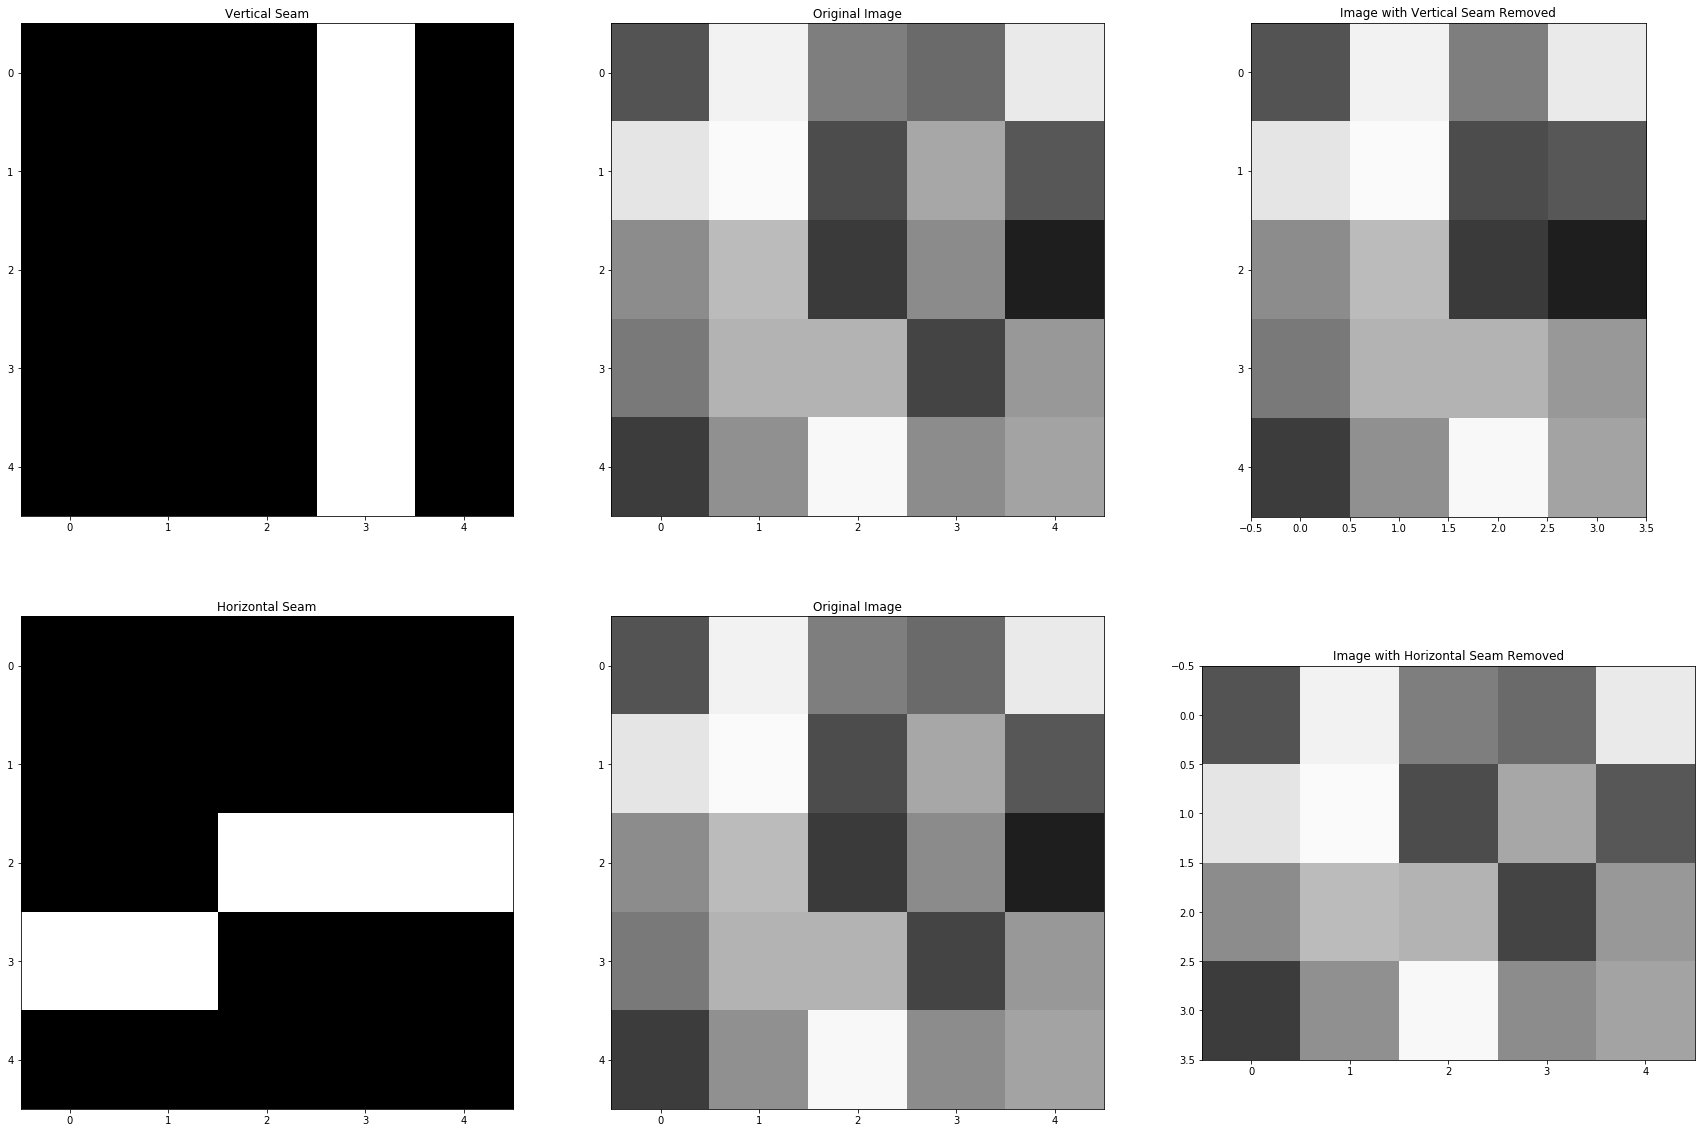

In [116]:
fig, ax = plt.subplots(2, 3, figsize=(30, 20))
ax[0, 0].imshow(vSeam)
ax[0, 0].set_title('Vertical Seam')
ax[0, 1].imshow(img)
ax[0, 1].set_title('Original Image')
ax[0, 2].imshow(img1)
ax[0, 2].set_title('Image with Vertical Seam Removed')
ax[1, 0].imshow(hSeam)
ax[1, 0].set_title('Horizontal Seam')
ax[1, 1].imshow(img)
ax[1, 1].set_title('Original Image')
ax[1, 2].imshow(img2)
ax[1, 2].set_title('Image with Horizontal Seam Removed')
plt.show()